# Mastering Scene Understanding: Scene Graphs to the Rescue
## Scene Graphs applied to Image Captioning 
-----
### Comprehensive Image Captioning via Scene Graph Decomposition, ECCV 2020
This notebook is based on the [official implementation](https://github.com/YiwuZhong/Sub-GC) for [Comprehensive Image Captioning via Scene Graph Decomposition, ECCV 2020](https://www.ecva.net/papers/eccv_2020/papers_ECCV/papers/123590205.pdf).

### Setting up the Environment and Data
Download [environment.yml](https://github.com/gabrielsantosrv/Sub-GC/blob/master/environment.yml) and run:
```conda env create -f environment.yml``` 
```conda activate sub_gc```

### Download data
We are going to run inference on the flickr30k dataset. So, before running this notebook, you should download the files below from this [repo](https://drive.google.com/drive/folders/1Hd97KB7eBn-HC1LoPpje8RunL599Kkgm) and  move them to `data`.

- `flickr30k_graph_mask_1000_rm_duplicate.zip`
- `flickr30k_gt_graph_mask.zip`
- `flickr30k_sg_output_64.zip` 
- `flickr30ktalk_label.h5`
- `flickr30ktalk.json`
- `flickr30k_img_wh.npy`
- `glove.6B.300d.pt`
- `gvd_all_dict.npy`
- `sct_dict_test_grouped_gt_box.npy`

Also, download the [misc](https://drive.google.com/drive/folders/1CKnVaJu4jYppy0Jlw6vjDNVJo7MVK-pP) and its subdirectories and [pretrained/sub_gc_flickr](https://drive.google.com/drive/folders/1qj3RiuUiXE-bd9tphDBSOKPrQGs0zu3m). Finally, download flickr30k image set [flickr30k_images](https://www.kaggle.com/datasets/hsankesara/flickr-image-dataset).

Please make sure that the final folder structure is the following:
```
├── data
│   ├── flickr30k_sg_output_64
│   │   ├── 36979.npz
│   │   ├── ...
│   │   └── 8251604257.npz
│   ├── flickr30k_graph_mask_1000_rm_duplicate
│   │   ├── 36979.npz
│   │   ├── ...
│   │   └── 8251604257.npz
│   ├── flickr30k_gt_graph_mask
│   │   ├── 36979.npz
│   │   ├── ...
│   │   └── 8251604257.npz
│   ├── flickr30ktalk_label.h5
│   ├── flickr30ktalk.json
│   ├── flickr30k_img_wh.npy
│   ├── glove.6B.300d.pt
│   ├── gvd_all_dict.npy
│   └── sct_dict_test_grouped_gt_box.npy
│
├── misc
│   ├── consensus_reranking
│   │   ├── image_features_mRNN
│   │   │   ├── res_feat_101_dct_flickr30k.npy
│   │   │   └── res_feat_101_dct_mscoco_2014.npy
│   │   └── mscoco_anno_files
│   │       ├── anno_list_mscoco_trainModelVal_m_RNN.npy
│   │       ├── flickr30k_karpathy_train_val_anno_list.npy
│   │       └── karpathy_train_val_anno_list.npy
│   └── grounding
│       └── flickr30k_cleaned_class.json
│
├── pretrained    
│   └── sub_gc_flickr
│       ├── infos_topdown-16000.pkl
│       └── model-16000.pth
│
└── flickr30k_images
```

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Load model and dataset used for inference. Note that to save time, this data loader already contains the pre-processed visual features and scene graphs.

In [2]:
import json
from argparse import Namespace

import torch

import misc.utils as utils
import models
from dataloaders.dataloader_test import DataLoader

# Load the configs needed for the text generation
with open("./config.json") as f:
    config = json.load(f)

# Load the model into the GPU
opt = Namespace(**config)
model = models.setup(opt)
model.load_state_dict(torch.load(opt.model))
model.cuda()

# Load the vocabulary
infos_path = "pretrained/sub_gc_flickr/infos_topdown-16000.pkl"
with open(infos_path, "rb") as f:
    infos = utils.pickle_load(f)

# Load the dev dataset
loader = DataLoader(opt)
loader.ix_to_word = infos["vocab"]  # set the vocabulary, allowing ix -> word mapping

loading word vectors from data/glove.6B.300d.pt


/home/gabriel.santos/Sub-GC_original/misc/utils.py:422: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(fname_pt)


Fail on __background__
loading word vectors from data/glove.6B.300d.pt
Fail on __background__


/tmp/ipykernel_3432378/475616491.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(opt.model))


DataLoader loading json file:  data/flickr30ktalk.json
vocab size is  8511
DataLoader loading h5 file:  data/flickr30ktalk_label.h5
max sequence length in data is 20
read 31014 image features
assigned 29000 images to split train
assigned 1014 images to split val
assigned 1000 images to split test


Load grounding information used to which objects are taken into account in the caption generation.

In [3]:
from collections import defaultdict

import numpy as np

num_images = config["num_images"]
split = config["split"]
lang_eval = config["language_eval"]
os.environ["REMOVE_BAD_ENDINGS"] = str(config["remove_bad_endings"])  # a global configuration

gvd_all_dict = np.load("data/gvd_all_dict.npy", allow_pickle=True, encoding="latin1").tolist()
wd_to_lemma = gvd_all_dict["wd_to_lemma"]
lemma_det_id_dict = gvd_all_dict["lemma_det_id_dict"]
det_id_to_det_wd = gvd_all_dict["det_id_to_det_wd"]
grd_output = defaultdict(list)
model_path = config["infos_path"].split("/")
consensus_rerank_file = model_path[0] + "/" + model_path[1] + "/consensus_rerank_ind.npy"
grd_sGPN_consensus = True if os.path.isfile(consensus_rerank_file) else False

### Caption generation


To start generating the captions for the Flickr30k data, set the model to the evaluation mode and reset the data loader.

In [4]:
model.eval()
loader.reset_iterator(split)

In this example, we generate captions for 10 images from Flickr30K. First, we sample an example where the visual and scene graph features were previously extracted. Then, the image captioning model is fed these features and returns 10 generated captions (one for each sub-scene graph) along with the sub-graph scores. Finally, we pick the caption generated from the sub-graph with the highest score.

In [5]:
from misc.grd_utils import get_grounding_material

predictions = []
for i in range(10):
    data = loader.get_batch(split)  # sample an example

    # visual features
    fc_feats = data["fc_feats"].cuda()
    att_feats = data["att_feats"].cuda()
    labels = data["labels"].cuda()
    masks = data["masks"].cuda()
    att_masks = data["att_masks"].cuda()

    # scene graph features
    trip_pred = data["trip_pred"]
    obj_dist = data["obj_dist"].cuda()
    obj_box = data["obj_box"]
    rel_ind = data["rel_ind"].cuda()
    pred_fmap = data["pred_fmap"]
    pred_dist = data["pred_dist"].cuda()
    gpn_obj_ind = data["gpn_obj_ind"].cuda()
    gpn_pred_ind = data["gpn_pred_ind"].cuda()
    gpn_nrel_ind = data["gpn_nrel_ind"].cuda()
    gpn_pool_mtx = data["gpn_pool_mtx"].cuda()

    # pass all subgraphs of an image to the model to generate sentences
    with torch.no_grad():
        seqq, seqLogprobs, subgraph_score, keep_nms_ind, att_weights = model(
            fc_feats,
            att_feats,
            att_masks,
            trip_pred,
            obj_dist,
            obj_box,
            rel_ind,
            pred_fmap,
            pred_dist,
            gpn_obj_ind,
            gpn_pred_ind,
            gpn_nrel_ind,
            gpn_pool_mtx,
            opt=config,
            mode="sample",
        )

        # sort the sub-graphs based on their scores
        sorted_score, sort_ind = torch.sort(subgraph_score, descending=True)
        seq = seqq[sort_ind].data
        subgraph_score = sorted_score.data
        sorted_subgraph_ind = keep_nms_ind[sort_ind]  # the indices are to index sub-graph in original order

    print(f"Example #{i}:")
    captions = utils.decode_sequence(loader.get_vocab(), seq)  # decode the caption

    # select the best caption based on the subgraph score
    best_ind = torch.argmax(subgraph_score).item()

    entry = {
        "image_id": data["infos"][0]["id"],
        "caption": captions,
        "best_caption": captions[best_ind],
    }

    predictions.append(entry)

    print(f"keeping top-{len(captions)} subgraphs")
    print(f"Best caption: {entry["best_caption"]}")
    print("--" * 20)

    # collect grounding material for grounding evaluation
    get_grounding_material(
        config["infos_path"],
        data,
        captions,
        sorted_subgraph_ind,
        att_weights,
        sort_ind,
        wd_to_lemma,
        lemma_det_id_dict,
        det_id_to_det_wd,
        grd_output,
        use_full_graph=not model.gpn,
        grd_sGPN_consensus=grd_sGPN_consensus,
    )


Example #0:
keeping top-10 subgraphs
Best caption: a man with a hat and a beard is wearing a straw hat
----------------------------------------
Example #1:
keeping top-10 subgraphs
Best caption: a dog runs through a field
----------------------------------------
Example #2:
keeping top-10 subgraphs
Best caption: a woman in a white karate gi is practicing martial arts
----------------------------------------
Example #3:
keeping top-10 subgraphs
Best caption: a group of people are standing in the snow
----------------------------------------
Example #4:
keeping top-10 subgraphs
Best caption: two men are working on a roof
----------------------------------------
Example #5:
keeping top-10 subgraphs
Best caption: a man in a white shirt and a man in a white shirt are taking pictures
----------------------------------------
Example #6:
keeping top-10 subgraphs
Best caption: a group of people are standing in the snow
----------------------------------------
Example #7:
keeping top-10 subgraph

To evaluate the generated captions, we plotted the images, their generated captions, and the grounding objects. In this way, we can verify whether the model is generating accurate descriptions and which objects are being taken into account.

In [9]:
from PIL import Image, ImageDraw


def draw_single_box(pic, box, color="red", draw_info=None):
    draw = ImageDraw.Draw(pic)
    x1, y1, x2, y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
    draw.rectangle(((x1, y1), (x2, y2)), outline=color)
    if draw_info:
        draw.rectangle(((x1, y1), (x1 + 50, y1 + 10)), fill=color)
        info = draw_info
        draw.text((x1, y1), info)


def draw_image(img_path, boxes, labels):
    pic = Image.open(img_path)
    num_obj = boxes.shape[0]
    for i in range(num_obj):
        info = labels[i]
        draw_single_box(pic, boxes[i], draw_info=info)
    display(pic)

    return None


a man with a hat and a beard is wearing a straw hat
a man wearing a hat and sunglasses
a man wearing a hat and sunglasses
a man wearing a hat and sunglasses
a man wearing a hat and sunglasses
a man wearing a straw hat and sunglasses
a man wearing a hat and sunglasses
a man wearing a hat and sunglasses
a man wearing a hat and sunglasses
a person in a red jacket is a white shirt
==> Best caption: a man with a hat and a beard is wearing a straw hat


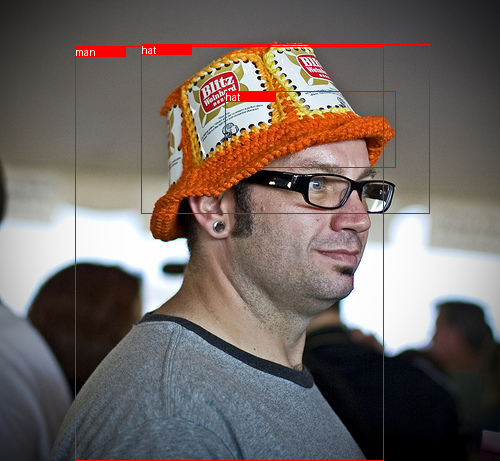

a dog runs through a field
a dog runs through the grass
a dog runs through a fenced in area
a dog runs through the grass
a dog runs through the grass
a dog runs through the grass
a dog jumps over a fence
a dog runs through the grass
a dog runs through the grass
a dog runs through the grass
==> Best caption: a dog runs through a field


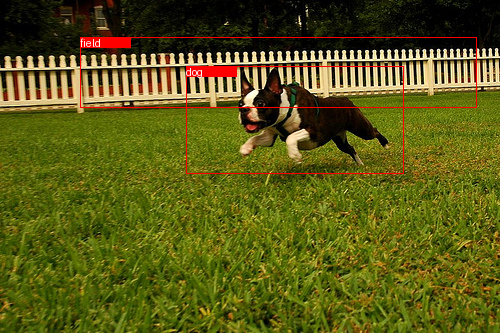

a woman in a white karate gi is practicing martial arts
a martial arts martial arts martial arts class is practicing martial arts
a young girl in a karate uniform is practicing martial arts
a young girl in a white karate gi is practicing martial arts
a woman in a white karate gi is practicing martial arts
a young girl in a white karate gi is practicing martial arts
two young girls in white karate uniforms are practicing martial arts
a young man in a karate uniform is practicing martial arts
a young woman in a karate uniform is practicing martial arts
a young girl in a karate uniform is practicing martial arts
==> Best caption: a woman in a white karate gi is practicing martial arts


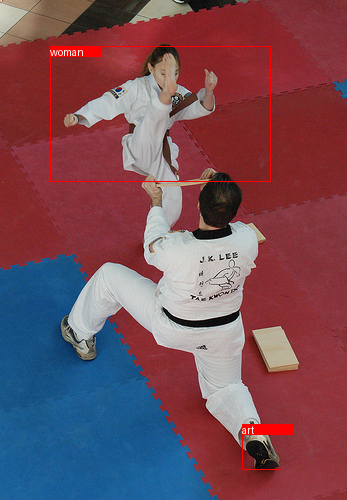

a group of people are standing in the snow
a group of people are walking in the snow
a group of people in helmets and helmets are walking in the snow
a group of people in helmets and helmets are standing in the snow
a group of people are ice skating
a group of people in winter coats are standing in the snow
a group of people in winter coats are walking in the snow
a group of people in winter coats are standing in the snow
a group of men and women are walking in the snow
a man and a woman are walking in the snow
==> Best caption: a group of people are standing in the snow


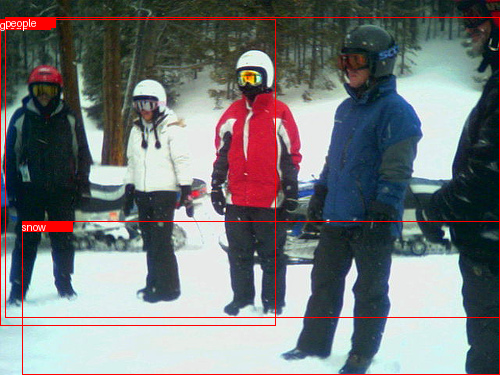

two men are working on a roof
two men are working on a roof
two men are working on a roof
two people are working on a roof
two men are working on a roof
two men are working on a roof
two men are working on a roof
two men are working on a roof
two men are working on a roof
two men are working on a roof
==> Best caption: two men are working on a roof


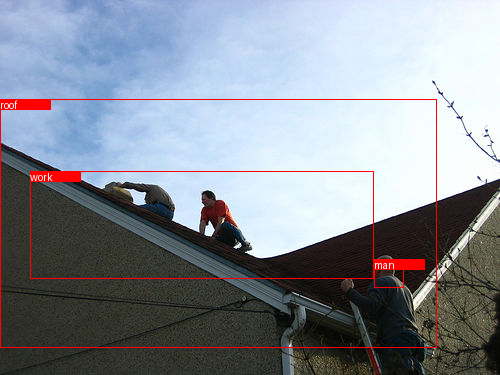

a man in a white shirt and a man in a white shirt are taking pictures
a man in a white shirt and a woman in a white shirt are standing in front of a
a man in a tuxedo is standing in front of a group of men in tuxedos
a man taking a picture of a group of people
a man in a white shirt and a woman in a white shirt are taking pictures
a group of people in suits and ties are standing in a circle
a man in a white shirt and blue tie is standing in front of a group of men in white
a photographer taking a picture of a photographer
a group of men in suits and ties are standing in a line in front of a tree
a man taking a picture of a group of men
==> Best caption: a man in a white shirt and a man in a white shirt are taking pictures


a group of people are standing in the snow
a man in a red jacket is standing in the snow with a group of people
a group of people are standing in the snow
a group of men are standing in the snow
a group of people are standing in the snow
a group of people in winter coats are standing in the snow
a group of people are standing in the snow
a group of people are standing in the snow
a group of people are standing in the snow
a group of people in winter coats are standing in the snow
==> Best caption: a group of people are standing in the snow


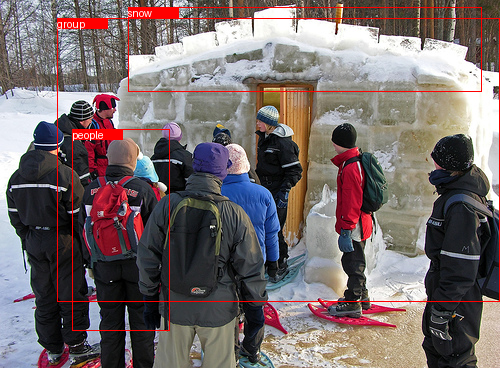

a baseball player in a red uniform is sliding into home plate
a baseball player in a red uniform is sliding into home plate while a catcher and umpire watch
a baseball player is about to catch a ball
a baseball player in a red uniform is throwing a ball into a base while a catcher and umpire watch
a baseball player in a purple uniform is sliding into home plate
a baseball player in a red uniform is sliding into home plate
a baseball player in a white uniform is sliding into a base while a baseball player in a white uniform
a baseball player in a purple uniform is sliding into home plate while a catcher and umpire look on
a baseball player in a red and white uniform is sliding into home plate while a catcher and umpire watch
a baseball player in a red uniform is sliding into home plate
==> Best caption: a baseball player in a red uniform is sliding into home plate


a man in a white shirt is working on a scaffold
a construction worker is working on a building
a man is working on scaffolding
a construction worker is working on a building
a man is working on a scaffold
a man is working on a scaffold
a man is working on a scaffold
a man is working on scaffolding
a man is working on scaffolding
a construction worker is working on a building
==> Best caption: a man in a white shirt is working on a scaffold


a man and a woman are sitting on a chair in front of a building
a man and a woman are sitting on a chair in front of a red chair
a man in a yellow shirt is sitting in a chair with a yellow box
a man and a woman are sitting on a chair in front of a red chair
a man and a woman are sitting on a chair in a street
a man and a woman are sitting on a chair in front of a store
a man and a woman sit on a chair in a public area
a man and a woman are sitting on a chair in a street
two people are sitting in a chair
a man and a woman are sitting on a chair in front of a red chair
==> Best caption: a man and a woman are sitting on a chair in front of a building


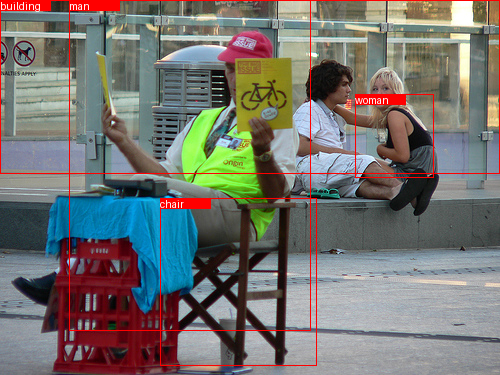

In [11]:
for i in range(10):
    image_id = predictions[i]["image_id"]
    captions = predictions[i]["caption"]
    best_caption = predictions[i]["best_caption"]

    for caption in captions:
        print(caption)

    print("==> Best caption:", best_caption)

    image_path = f"flickr30k_images/{image_id}.jpg"
    boxes = torch.Tensor(grd_output[image_id][0]["bbox"])
    label = grd_output[image_id][0]["clss"]
    draw_image(image_path, boxes, label)
    print("=" * 100)
